In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import os
path = os.getcwd()
abspath = os.path.abspath(os.path.join(path, os.pardir))
path = abspath + '/imagesMasks'

In [3]:
num_skipped = 0
for folder_name in ("Faces", "Masks"):
    folder_path = os.path.join(path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


In [4]:
!pip install deepface
from deepface import DeepFace
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
!pip install cmake
!pip install dlib

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
pathImageFolder = path                             
folderList = os.listdir(pathImageFolder)

In [33]:
for folder in folderList:
   
    pathFolder = pathImageFolder + '/' + folder 
    myFiles = [f for f in os.listdir(pathFolder) if f.endswith('.jpg')]
    
    print(folder)
    
    for file in range(len(myFiles)):
                
        file_name = myFiles[file]
        
        print(pathFolder + file_name)
        
        try:
            face = DeepFace.detectFace(img_path = pathFolder + '/' + file_name, target_size = (224, 224), detector_backend = "dlib")
            plt.imsave(pathFolder + '/' + file_name, face)
        except ValueError:
            print(ValueError)
            print(file_name)
            os.remove(pathFolder + '/' + file_name)

Faces
/tf/src/imagesMasks/Faces001_ca88905d.jpg
/tf/src/imagesMasks/Faces002_cdf6d7df.jpg
/tf/src/imagesMasks/Faces003_a49240ab.jpg
/tf/src/imagesMasks/Faces004_1b3267f6.jpg
/tf/src/imagesMasks/Faces005_2a95ab84.jpg
/tf/src/imagesMasks/Faces006_4a189018.jpg
/tf/src/imagesMasks/Faces007_10018649.jpg
/tf/src/imagesMasks/Faces008_43a2fc3f.jpg
/tf/src/imagesMasks/Faces009_87902fef.jpg
/tf/src/imagesMasks/Faces011_93d9a710.jpg
/tf/src/imagesMasks/Faces012_4cd8bf0e.jpg
/tf/src/imagesMasks/Faces013_b512257e.jpg
/tf/src/imagesMasks/Faces014_39431dee.jpg
/tf/src/imagesMasks/Faces015_ef7480f2.jpg
/tf/src/imagesMasks/Faces016_b0f2957a.jpg
/tf/src/imagesMasks/Faces017_32fd034b.jpg
/tf/src/imagesMasks/Faces018_52c2a3bb.jpg
/tf/src/imagesMasks/Faces019_c7d9e209.jpg
/tf/src/imagesMasks/Faces020_af0a00e4.jpg
/tf/src/imagesMasks/Faces022_895d3a95.jpg
/tf/src/imagesMasks/Faces024_c87a91bf.jpg
/tf/src/imagesMasks/Faces025_adabf31f.jpg
/tf/src/imagesMasks/Faces026_f92b0bc1.jpg
/tf/src/imagesMasks/Faces027

## Generate a `Dataset`


In [6]:
image_size = (224, 224)
batch_size = 2

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 165 files belonging to 2 classes.
Using 132 files for training.
Found 165 files belonging to 2 classes.
Using 33 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".


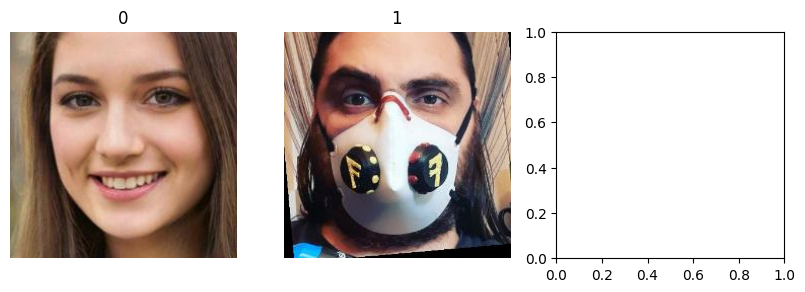

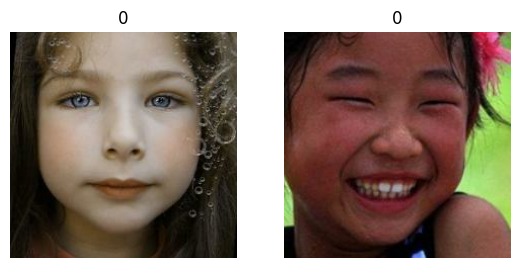

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(2):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


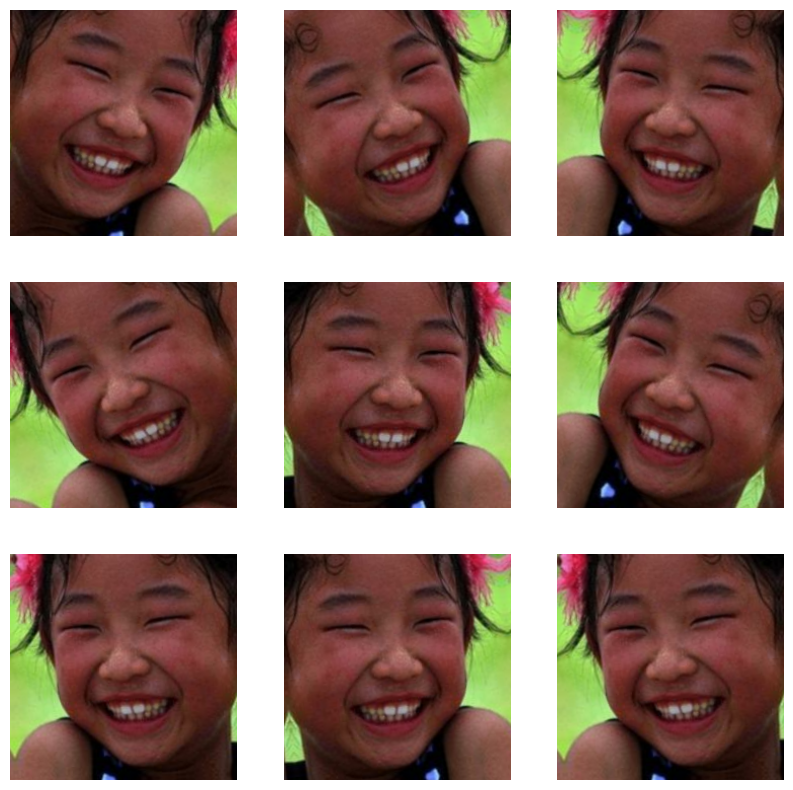

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [11]:
train_ds = train_ds.prefetch(buffer_size=2)
val_ds = val_ds.prefetch(buffer_size=2)


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


In [12]:
pip install pydot

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


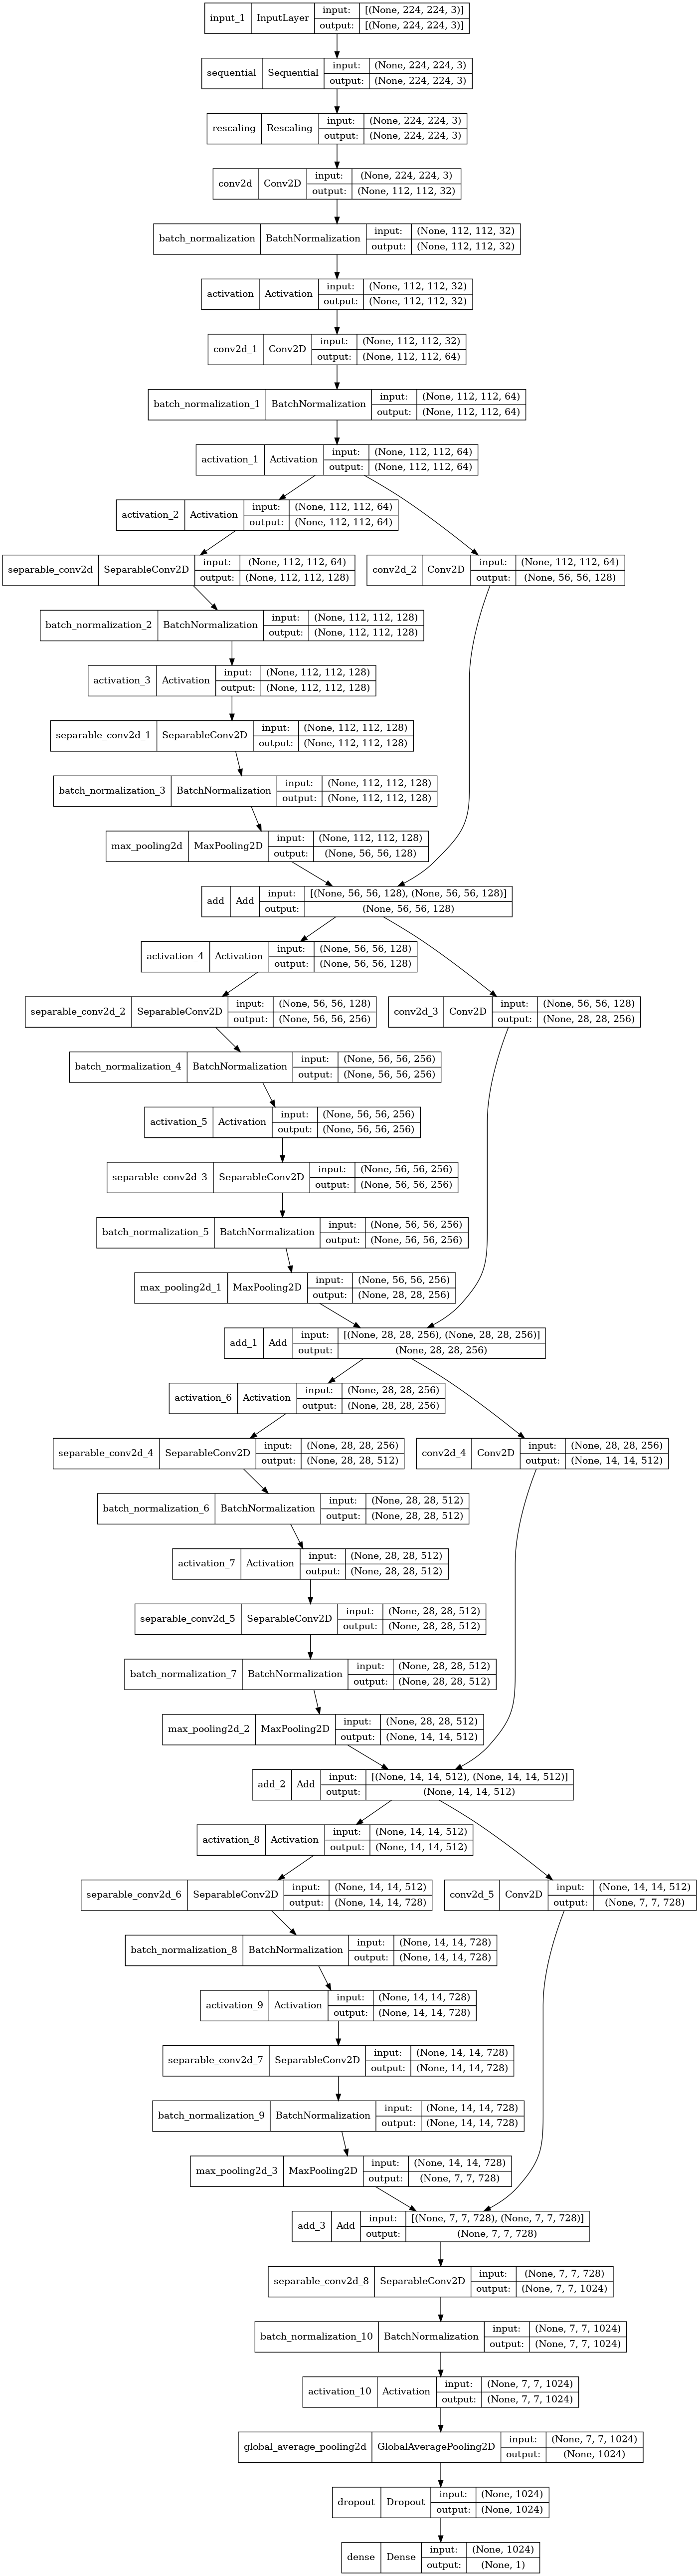

In [13]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## Train the model


In [14]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [15]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard
%tensorboard --logdir logs/fit/ --host 0.0.0.0

In [16]:
epochs = 50

callbacks = [
    #keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
)


Epoch 1/50
66/66 [==============================] - 8s 58ms/step - loss: 0.7351 - accuracy: 0.5985 - val_loss: 0.7125 - val_accuracy: 0.4848
Epoch 2/50
66/66 [==============================] - 3s 47ms/step - loss: 0.7175 - accuracy: 0.6818 - val_loss: 0.7940 - val_accuracy: 0.4848
Epoch 3/50
66/66 [==============================] - 3s 49ms/step - loss: 0.6968 - accuracy: 0.6667 - val_loss: 0.9898 - val_accuracy: 0.4848
Epoch 4/50
66/66 [==============================] - 3s 49ms/step - loss: 0.6945 - accuracy: 0.5985 - val_loss: 1.3783 - val_accuracy: 0.4848
Epoch 5/50
66/66 [==============================] - 3s 47ms/step - loss: 0.5640 - accuracy: 0.7348 - val_loss: 0.8525 - val_accuracy: 0.4848
Epoch 6/50
66/66 [==============================] - 3s 48ms/step - loss: 0.6776 - accuracy: 0.7045 - val_loss: 1.2387 - val_accuracy: 0.4848
Epoch 7/50
66/66 [==============================] - 3s 47ms/step - loss: 0.6147 - accuracy: 0.7197 - val_loss: 0.6539 - val_accuracy: 0.6061
Epoch 8/50
66

We get to ~96% validation accuracy after training for 50 epochs on the full dataset.


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


In [23]:
img = keras.preprocessing.image.load_img(
    f"{path}/Masks/613_68b1906b.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Face and %.2f percent Mask."
    % (100 * (1 - score), 100 * score)
)


This image is 18.66 percent Face and 81.34 percent Mask.
